# Install the required packages

In [5]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip3 install numpy
!pip3 install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


# Import the required packages

In [8]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

# Define the transformations to prepare the data

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

1. ```transforms.ToTensor()``` converts the image to a tensor
2. ```transforms.Normalize((0.5,), (0.5,))``` normalizes the image

# Download the dataset

In [11]:
!mkdir data
!mkdir data/train
!mkdir data/test

trainset = datasets.MNIST('data/train', download=True, train=True, transform=transform)

valset = datasets.MNIST('data/test', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

1.3%

100.0%


Extracting data/train/MNIST/raw/train-images-idx3-ubyte.gz to data/train/MNIST/raw



100.0%

Extracting data/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/train/MNIST/raw




100.0%
100.0%


Extracting data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/train/MNIST/raw

Extracting data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/train/MNIST/raw



1.3%

100.0%


Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw



100.0%
7.9%

Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw



100.0%


Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw



100.0%

Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw



# Analyze the dataset

In [14]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


The batch size is 64 and the image size is 28x28 and the number of channels is 1 (grayscale)
The labels are the corresponding numbers for the images

In [15]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [17]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [ 0.0038,  0.0038,  0.0038,  ...,  0.0038,  0.0038,  0.0038],
        ...,
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007]])


In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6254715747368742
Epoch 1 - Training loss: 0.2859874404609394
Epoch 2 - Training loss: 0.22705557044428676
Epoch 3 - Training loss: 0.18594326757228197
Epoch 4 - Training loss: 0.1529723675941417
Epoch 5 - Training loss: 0.13098233769625933
Epoch 6 - Training loss: 0.1131098916742212
Epoch 7 - Training loss: 0.09990213626473428
Epoch 8 - Training loss: 0.0889287746217507
Epoch 9 - Training loss: 0.08043057733882608
Epoch 10 - Training loss: 0.07318923629816375
Epoch 11 - Training loss: 0.06614594339385137
Epoch 12 - Training loss: 0.061564421565927216
Epoch 13 - Training loss: 0.05646899217359428
Epoch 14 - Training loss: 0.05292391805410155

Training Time (in minutes) = 1.6264832854270934


In [23]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 3


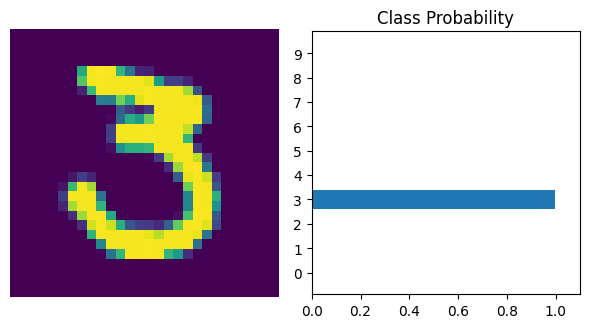

In [24]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [25]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9743


In [26]:
!mkdir models
torch.save(model, 'models/mnist_model.pt')